# Predicting NBA Players' Salary Through Random Forest Model

### Weon Gyu Jeon

## 1. Introduction  
After building a [linear regression model using 2024–25 traditional stats](https://www.kaggle.com/code/ratin21/predicting-nba-salary-through-linear-regression), I wanted to try a more flexible, non-linear method to improve prediction performance. For this notebook, I used a Random Forest Regressor — an ensemble method that typically performs well without much feature scaling or heavy tuning.

As always, the goal is to predict **NBA players' salary for the 2024–25 season** based solely on their performance statistics from the same season.

## 2. Preparation  

### 2.1 Packages and Libraries

In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

### 2.2 Data Preparation
CSV file for player salary in 2024-25 season was scrapped from [Basketball Reference](https://www.basketball-reference.com/contracts/players.html).
CSV file for player stats can be easily acquired from [Basketball Reference](https://www.basketball-reference.com/leagues/NBA_2025_per_game.html) too.

In [216]:
salarydf = pd.read_csv("NBA Player Salaries_2024-25_1.csv")
statsdf = pd.read_csv("NBA Player Stats_2024-25_Per_Game.csv")

#### 2.2.1 Data Component
Here is how the data looks like, before cleaning.

In [218]:
pd.set_option('display.max_columns', None)
statsdf.head(1)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Shai Gilgeous-Alexander,26,OKC,PG,76,76,34.2,11.3,21.8,0.519,2.1,5.7,0.375,9.2,16.1,0.571,0.569,7.9,8.8,0.898,0.9,4.1,5.0,6.4,1.7,1.0,2.4,2.2,32.7


In [219]:
salarydf.head(1)

,Player,Team,Salary
0,Stephen Curry,GSW,"$55,761,216"


### 2.3 Data Cleaning

#### 2.3.1 Salary Data
So for Salary Data, I had to:
1) remove dollar signs from 'Salary' column and change data type to integer so that it's calculatable
2) strip whitespaces from 'Player' column if there is any
3) check null values
4) finally, drop duplicate rows, of course

In [222]:
salarydf['Salary'] = salarydf['Salary'].replace(r'[\$,]', '', regex=True).astype(int)

salarydf['Player'] = salarydf['Player'].str.strip()

# print(salarydf.isnull().sum())

salarydf = salarydf.drop_duplicates()

#### 2.3.2 Stats Data

For stats data, I had to deal with player entries who played for multiple teams this season. If a player moved teams once within the season, Basketball Reference's record puts three entries separate:
1) player's total stats recorded in both teams
2) stats recorded in the first team
3) stats recorded in the second team

e.g. Zach Lavine played for CHI and SAC this season, then there are three entries for him: 2TM, CHI, SAC

So I cleaned it by counting the number of entries that one player has, filtered it, and saved entries that has their full stats this season.

In [224]:
# Step 1: find players played for multiple teams
duplicate_players = statsdf['Player'].value_counts()
multi_team_players = duplicate_players[duplicate_players > 1].index

In [225]:
# Step 2: Separately filter players (multi and single)
multi_team_rows = statsdf[statsdf['Player'].isin(multi_team_players)]
single_team_rows = statsdf[~statsdf['Player'].isin(multi_team_players)]

In [226]:
# Step 3: Combine the single-team rows with the multi-team rows that we will keep (one row per player, only)
# Here, we're keeping the very first row for each player in multi_team_rows (the one with '2TM', '3TM', etc.)
summary_rows = multi_team_rows.drop_duplicates(subset='Player', keep='first')
cleaned_statsdf = pd.concat([single_team_rows, summary_rows], ignore_index=True)

Then,
1) removed 'Rk' column which doesn't contain any meaning
2) stripped whitespaces in player names
3) check for null values

In [228]:
cleaned_statsdf = cleaned_statsdf.drop(columns=['Rk'], errors='ignore')

cleaned_statsdf['Player'] = cleaned_statsdf['Player'].str.strip()

cleaned_statsdf = cleaned_statsdf.fillna(0)

### 2.4 Merging Datasets

In [230]:
stats_salary = pd.merge(cleaned_statsdf, salarydf[['Player', 'Salary']], on='Player', how='inner')

#### 2.4.1 Further Cleaning

In [232]:
stats_salary = stats_salary.drop_duplicates()

stats_salary = stats_salary.reset_index(drop=True)

## 3. Testing Different Non-Linear Regressions

I tried various popular non-linear regression models here to compare and contrast the performance: **Random Forest, Gradient Boosting, XGBoost and Extra trees**. <br> Then, I also differentiated sets of independent variables to 1) **limited features**, which refers to some most-used traditional stats (PTS, AST, REB, STL, BLK, and Age), 2) **all features**, which is basically all the traditional stats included in stats dataset. 
<br>
The reason why I did this is just to find and use the best-performing model to predict player's salary, although all of the model will be called in a default setting without further tuning. It is just a simple and fun observation to make.

#### Feature sets

In [235]:
limited_features = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age']
all_features = [col for col in stats_salary.columns if col not in ['Player', 'Team', 'Pos', 'Salary', 'Year']]

### 3.1 Helper Functions

#### Function to evaluate and print testing results

In [238]:
def evaluate_model(model, name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Results:")
    print(f"RMSE: ${rmse :,.2f}")
    print(f"R^2 Score: {r2:.4f}\n")
    return {'name': name, 'rmse': rmse, 'r2': r2}

#### Function to get scaled data

In [240]:
def get_scaled_train_test_split(dataframe, feature_set, target_col='Salary', test_size=0.2, random_state=42):
    X = dataframe[feature_set]
    y = dataframe[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

#### Function to evaluate model on both feature sets

In [242]:
def evaluate_model_on_two_feature_sets(dataframe, feature_set_1, feature_set_2, model_class, model_name):
    # Evaluate on first feature set
    X_train_1, X_test_1, y_train_1, y_test_1 = get_scaled_train_test_split(dataframe, feature_set_1)
    evaluate_model(model_class(), f"{model_name} {feature_set_1}", X_train_1, X_test_1, y_train_1, y_test_1)

    # Evaluate on second feature set
    X_train_2, X_test_2, y_train_2, y_test_2 = get_scaled_train_test_split(dataframe, feature_set_2)
    evaluate_model(model_class(), f"{model_name} {feature_set_2}", X_train_2, X_test_2, y_train_2, y_test_2)

### 3.2 Results

#### Random Forest Results

In [245]:
evaluate_model_on_two_feature_sets(stats_salary, limited_features, all_features, RandomForestRegressor, "Random Forest")

Random Forest ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age'] Results:
RMSE: $8,468,548.82
R^2 Score: 0.6020

Random Forest ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] Results:
RMSE: $8,525,708.98
R^2 Score: 0.5966



#### Gradient Boosting Results

In [247]:
evaluate_model_on_two_feature_sets(stats_salary, limited_features, all_features, GradientBoostingRegressor, "Gradient Boosting")

Gradient Boosting ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age'] Results:
RMSE: $9,297,996.41
R^2 Score: 0.5203

Gradient Boosting ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] Results:
RMSE: $8,638,931.79
R^2 Score: 0.5859



#### XGBoost Results

In [249]:
evaluate_model_on_two_feature_sets(stats_salary, limited_features, all_features, xgb.XGBRegressor, "XGBoost")

XGBoost ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age'] Results:
RMSE: $9,416,485.47
R^2 Score: 0.5079

XGBoost ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] Results:
RMSE: $8,954,838.87
R^2 Score: 0.5550



#### Extra Trees Results

In [251]:
evaluate_model_on_two_feature_sets(stats_salary, limited_features, all_features, ExtraTreesRegressor, "Extra Trees")

Extra Trees ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age'] Results:
RMSE: $8,830,299.67
R^2 Score: 0.5673

Extra Trees ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] Results:
RMSE: $9,047,253.24
R^2 Score: 0.5458



#### Result Summarized

| Rank | Model                 | **RMSE (Limited)** | **R² (Limited)** | **RMSE (All)** | **R² (All)** | **Avg R²** |
| ---- | --------------------- | ------------------ | ---------------- | -------------- | ------------ | ---------- |
| 1    | **Random Forest**     | \$8.60M            | 0.5897           | \$8.54M        | 0.5957       | **0.5927** |
| 2    | **Gradient Boosting** | \$9.21M            | 0.5291           | \$8.65M        | 0.5845       | **0.5568** |
| 3    | **Extra Trees**       | \$8.90M            | 0.5600           | \$9.19M        | 0.5312       | **0.5456** |
| 4    | **XGBoost**           | \$9.42M            | 0.5079           | \$8.95M        | 0.5550       | **0.5315** |

**Random Forest** performed the best. Although these non-linear regression models **give different results every time** we call (due to random train/test splits), there can be several reasons why Random Forest perofrmed the best, on average:
1) Random Forest often performs the best with default setting (without tuning) compared to other models.
2) Random Forest can capture nonlinear relationships and threshold naturally. NBA dataset includes a lot of 'salary jumps', where some players with certain threshold gets extreme salary boost. For instance, players with supermax contracts get paid significantly higher than others.
3) Random Forest deals well with overfitting with small and noisy dataset. And this dataset has just ~600 rows.

## 4. How about in a larger dataset?

As above, Random Forest model deals well with small and noisy dataset. How about larger one? I collected the same data but with a larger scale of **2010-2025**. Notebook that includes full process of data scrapping and cleaning can be found at my [Github Repository](https://github.com/edwinjeon/NBA-Salary-Prediction).

### 4.1 About this data

In [257]:
largerdf = pd.read_csv("NBA Player Stats and Salaries_2010-2025.csv")

#### 4.1.1 Data components

In [259]:
largerdf.head(1)

,Player,Salary,Year,Pos,Age,Team,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Kobe Bryant,23034375,2010,SG,31,LAL,73,73,38.8,9.8,21.5,0.456,1.4,4.1,0.329,8.5,17.4,0.487,0.488,6.0,7.4,0.811,1.1,4.3,5.4,5.0,1.5,0.3,3.2,2.6,27.0


As we can see, we have all the traditional stats and salary info in this dataset.

#### 4.1.2 Redefine set of features

In [262]:
limited_features = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age']
all_features = [col for col in largerdf.columns if col not in ['Player', 'Team', 'Pos', 'Salary']]

### 4.2 Testing with Random Forest

In [264]:
evaluate_model_on_two_feature_sets(largerdf, limited_features, all_features, RandomForestRegressor, "Random Forest")

Random Forest ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Age'] Results:
RMSE: $5,189,631.44
R^2 Score: 0.6092

Random Forest ['Year', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] Results:
RMSE: $4,241,462.21
R^2 Score: 0.7389



With a larger dataset to train on, Random Forest gave **better result** than the stats dataset with only one season. This is primarily because of two reasons:
1) More data (~600 entries on one season vs. ~7300 entries on 15 seasons)
2) 'Year' factor is now included, so now the model is capable to apply inflation of salary.

That being said, Let's use **larger set of stats with all of the features** for our prediction.

## 5. Hyperparameter Tuning with RandomizedSearchCV

To explore better hyperparameters for the Random Forest Regressor, I used `RandomizedSearchCV` library. This tool randomly samples from a specified parameter grid and evaluates performance using cross-validation.

#### Set of features, splitting, scaling

In [269]:
X = largerdf[all_features]
y = largerdf['Salary']

In [270]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

I used StandardScaler for scaling the training sets.

In [272]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Define the parameter distribution for RandomizedSearchCV

In [274]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

#### Create and fit the randomized search

In [276]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

I used 20 combinations of parameters and 3-fold cross-validation to evaluate them.

In [278]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, verbose=2)

#### 5.1 Evaluate the model

In [280]:
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("--- Random Forest Regression Results ---")
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")

--- Random Forest Regression Results ---
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}
RMSE: $4,199,705.10
R-squared (R²): 0.7440


#### 5.2 Results summary

| Model Configuration                | Hyperparameters                                                                            | RMSE (\$)    | R² Score |
| ---------------------------------- | ------------------------------------------------------------------------------------------ | ------------ | ------
 |
| **Tuned Random Forest w/RandomizedSearchCV**      | `n_estimators=100`, `min_samples_split=2`, `min_samples_leaf=4`, `max_depth=20`            | 4,199,705.10 | 0.7440   |
| **Default Random Forest** | `n_estimators=100`, `min_samples_split=2`, `min_samples_leaf=1`, `max_depth=None`  | 4,255,201.05 | 0.7372   |


As we can see from the table, tune with RandomizedSearchCV enhanced the testing result by some.

## 6. Analysis
Here is the visualization that shows importance of each features to salary in this model,

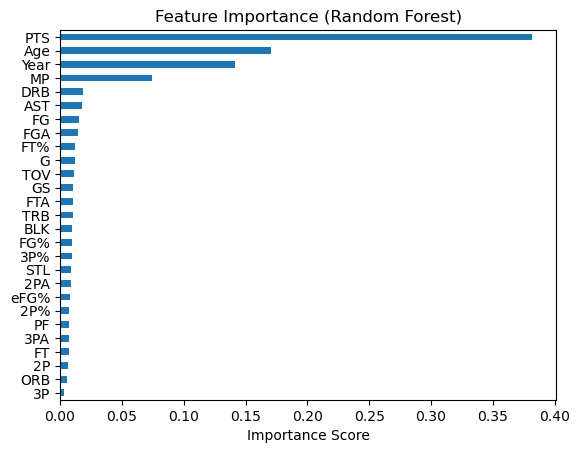

In [285]:
importances = best_rf.feature_importances_
feature_importance_df = pd.Series(importances, index=all_features).sort_values(ascending=False)

feature_importance_df.plot(kind='barh', title='Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

Four things that captured my eyes:
1) Points per game is still the strongest factor for player's salary.
2) Older players tend to get paid more.
3) Minutes a player plays is a strongest factor after points among traditional stats. More minutes you play, the more a player is important to the team.
4) As I mentioned above, salary increases as year goes on due to inflation.

## 7. Predictions

### 7.1 Prediction Function

In [289]:
def predict_salary(player_name, model, scaler, X_source, df):
    player_rows = df[df['Player'] == player_name]

    if player_rows.empty:
        print(f"Player '{player_name}' not found in the dataset.")
        return

    # Select the most recent season's stats
    player_row = player_rows[player_rows['Year'] == player_rows['Year'].max()].iloc[0]

    player_features = pd.DataFrame([player_row[X_source.columns]])

    scaled_features = scaler.transform(player_features)

    predicted_salary = model.predict(scaled_features)[0]

    actual_salary = player_row['Salary']

    print(f" Predicted 2025-26 season salary for {player_name}: ${predicted_salary:,.2f}")
    print(f" Current salary for {player_name}: ${actual_salary:,.2f}")

### 6.2 Predicting with actual players

As the model is predicting new salary for next year, let's try some players who have contracts expiring next year. 
<br>Let's first try with **James Harden**, who has player option for next season. His stats: 22.8 PTS, 8.7 AST, 5.8 REB, 0.7 BLK, 1.5 STL at age of 35.

In [292]:
predict_salary("James Harden", best_rf, scaler, X_test, largerdf)

 Predicted 2025-26 season salary for James Harden: $41,877,404.24
 Current salary for James Harden: $33,653,846.00


James Harden received **\\$33,653,846** this season,
<br>
The model says he will receive **\\$41,877,404** next season, with a significant raise.

**Lebron James** also has his player option for next season. His stats: 24.4 PTS, 8.2 AST, 7.8 REB, 0.6 BLK, 1 STL at the age of 40.

In [295]:
predict_salary("LeBron James", best_rf, scaler, X_test, largerdf)

 Predicted 2025-26 season salary for LeBron James: $48,353,299.77
 Current salary for LeBron James: $48,728,845.00


Lebron James received **\\$48,728,845** this season, <br>
The model says he will receive similar next season with **\\$48,353,299**.

Lastly, **Ty Jerome**, one of the best bench players this season, also gets Free Agent option this season. <br>
His stats: 12.5 PTS, 3.4 AST, 2.5 REB, 0 BLK, 1.1 STL at the age of 27.

In [298]:
predict_salary("Ty Jerome", best_rf, scaler, X_test, largerdf)

 Predicted 2025-26 season salary for Ty Jerome: $5,518,205.36
 Current salary for Ty Jerome: $2,560,975.00


Ty Jerome Received **\\$2,560,975** this season, <br>
The model predicts a some raise for him next season of **\\$5,518,205**.